## Use case: Gaussian Process Regression

### sklearn's documentation below ------------: https://github.com/scikit-learn/scikit-learn/blob/master/examples/gaussian_process/plot_gpr_noisy.py

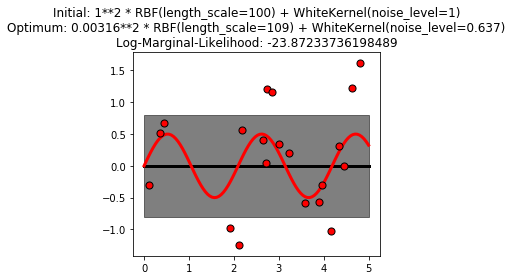

In [2]:
"""
=============================================================
Gaussian process regression (GPR) with noise-level estimation
=============================================================
This example illustrates that GPR with a sum-kernel including a WhiteKernel can
estimate the noise level of data. An illustration of the
log-marginal-likelihood (LML) landscape shows that there exist two local
maxima of LML. The first corresponds to a model with a high noise level and a
large length scale, which explains all variations in the data by noise. The
second one has a smaller noise level and shorter length scale, which explains
most of the variation by the noise-free functional relationship. The second
model has a higher likelihood; however, depending on the initial value for the
hyperparameters, the gradient-based optimization might also converge to the
high-noise solution. It is thus important to repeat the optimization several
times for different initializations.
"""
#print(__doc__)

# Authors: Jan Hendrik Metzen <jhm@informatik.uni-bremen.de>
#
# License: BSD 3 clause

import numpy as np

from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel


rng = np.random.RandomState(0)
X = rng.uniform(0, 5, 20)[:, np.newaxis]
y = 0.5 * np.sin(3 * X[:, 0]) + rng.normal(0, 0.5, X.shape[0])

# First run
plt.figure()
kernel = 1.0 * RBF(length_scale=100.0, length_scale_bounds=(1e-2, 1e3)) \
    + WhiteKernel(noise_level=1, noise_level_bounds=(1e-10, 1e+1))
gp = GaussianProcessRegressor(kernel=kernel,
                              alpha=0.0).fit(X, y)
X_ = np.linspace(0, 5, 100)
y_mean, y_cov = gp.predict(X_[:, np.newaxis], return_cov=True)
plt.plot(X_, y_mean, 'k', lw=3, zorder=9)
plt.fill_between(X_, y_mean - np.sqrt(np.diag(y_cov)),
                 y_mean + np.sqrt(np.diag(y_cov)),
                 alpha=0.5, color='k')
plt.plot(X_, 0.5*np.sin(3*X_), 'r', lw=3, zorder=9)
plt.scatter(X[:, 0], y, c='r', s=50, zorder=10, edgecolors=(0, 0, 0))
plt.title("Initial: %s\nOptimum: %s\nLog-Marginal-Likelihood: %s"
          % (kernel, gp.kernel_,
             gp.log_marginal_likelihood(gp.kernel_.theta)))
plt.tight_layout()

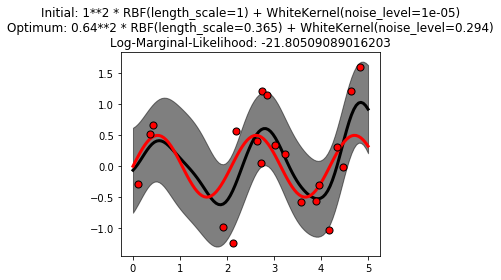

In [3]:
# Second run
plt.figure()
kernel = 1.0 * RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e3)) \
    + WhiteKernel(noise_level=1e-5, noise_level_bounds=(1e-10, 1e+1))
gp = GaussianProcessRegressor(kernel=kernel,
                              alpha=0.0).fit(X, y)
X_ = np.linspace(0, 5, 100)
y_mean, y_cov = gp.predict(X_[:, np.newaxis], return_cov=True)
plt.plot(X_, y_mean, 'k', lw=3, zorder=9)
plt.fill_between(X_, y_mean - np.sqrt(np.diag(y_cov)),
                 y_mean + np.sqrt(np.diag(y_cov)),
                 alpha=0.5, color='k')
plt.plot(X_, 0.5*np.sin(3*X_), 'r', lw=3, zorder=9)
plt.scatter(X[:, 0], y, c='r', s=50, zorder=10, edgecolors=(0, 0, 0))
plt.title("Initial: %s\nOptimum: %s\nLog-Marginal-Likelihood: %s"
          % (kernel, gp.kernel_,
             gp.log_marginal_likelihood(gp.kernel_.theta)))
plt.tight_layout()

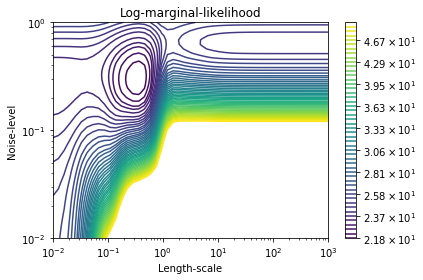

In [4]:
# Plot LML landscape
plt.figure()
theta0 = np.logspace(-2, 3, 49)
theta1 = np.logspace(-2, 0, 50)
Theta0, Theta1 = np.meshgrid(theta0, theta1)
LML = [[gp.log_marginal_likelihood(np.log([0.36, Theta0[i, j], Theta1[i, j]]))
        for i in range(Theta0.shape[0])] for j in range(Theta0.shape[1])]
LML = np.array(LML).T

vmin, vmax = (-LML).min(), (-LML).max()
vmax = 50
level = np.around(np.logspace(np.log10(vmin), np.log10(vmax), 50), decimals=1)
plt.contour(Theta0, Theta1, -LML,
            levels=level, norm=LogNorm(vmin=vmin, vmax=vmax))
plt.colorbar()
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Length-scale")
plt.ylabel("Noise-level")
plt.title("Log-marginal-likelihood")
plt.tight_layout()

plt.show()

### end of sklearn's documentation ------------

## Discussion

The main point that this documentation is making is that a Gaussian Process can learn the noise level from the data. Even beyond that, there is a deeper truth: Gaussian Processes can learn ***interpretable*** parameters. Unlike a neural network, with thousands or millions or Google-knows-how-many parameters, the parameters of a kernel describe the data in understandable ways, such as a length scale or relative component sizes. 

This documentation has a corollary however: the log likelihood surface is multimodal (or at least not unimodal in general)! This seems to be a trivial problem, and the sklearn authors treat it as such. However, this has complications. Namely,
 * Each maxima of the likelihood is a different ***interpretation*** of the dataset. If I am a weather scientist, I think I would want to know if I had 3 models: sunny (70% likelihood), cloudy (20%), and a sharknado-tsunami apocalypse granting everyone mutant powers (10%). This is a silly example, but illustrates that often ***both the error-in-the-model and the error-in-choosing-a-model are important***. I don't use the typical variance bias ML talk because Gaussian Processes are nonparametric.
 * The sklearn documentation seems to say: "well, we looked at the likelihood, and there are two maxima. so we just reran approximate Newton methods a few times, and wow, we got it." This is a good start, but there are a few problems with simply running Newton with restarts:
    * Newton's method is a derivative based method, so any edges or other types of maxima are not found
    * Running Newton's method many times means that often it will converge to the same points. If only there was a way to avoid that...
    * This doesn't take advantage of obvious parallelism when running Newton's method many times
    * In high dimensions, visualizing the likelihood surface like this is near impossible

In [5]:
import inspect

In [50]:
class bcolors:
    FAIL = '\033[91m'
    ENDC = '\033[0m'

In [52]:
text = inspect.getsource(GaussianProcessRegressor.fit).split('\n')
splits = 54, 95
for para in text[:splits[0]]: print(para)
for para in text[splits[0]:splits[1]]: print(bcolors.FAIL+para+bcolors.ENDC)
for para in text[splits[1]:]: print(para)

    def fit(self, X, y):
        """Fit Gaussian process regression model.

        Parameters
        ----------
        X : array-like of shape (n_samples, n_features) or list of object
            Feature vectors or other representations of training data.

        y : array-like of shape (n_samples,) or (n_samples, n_targets)
            Target values

        Returns
        -------
        self : returns an instance of self.
        """
        if self.kernel is None:  # Use an RBF kernel as default
            self.kernel_ = C(1.0, constant_value_bounds="fixed") \
                * RBF(1.0, length_scale_bounds="fixed")
        else:
            self.kernel_ = clone(self.kernel)

        self._rng = check_random_state(self.random_state)

        if self.kernel_.requires_vector_input:
            X, y = self._validate_data(X, y, multi_output=True, y_numeric=True,
                                       ensure_2d=True, dtype="numeric")
        else:
            X, y = self._validate_

In [55]:
print(inspect.getsource(GaussianProcessRegressor.fit))

    def fit(self, X, y):
        """Fit Gaussian process regression model.

        Parameters
        ----------
        X : array-like of shape (n_samples, n_features) or list of object
            Feature vectors or other representations of training data.

        y : array-like of shape (n_samples,) or (n_samples, n_targets)
            Target values

        Returns
        -------
        self : returns an instance of self.
        """
        if self.kernel is None:  # Use an RBF kernel as default
            self.kernel_ = C(1.0, constant_value_bounds="fixed") \
                * RBF(1.0, length_scale_bounds="fixed")
        else:
            self.kernel_ = clone(self.kernel)

        self._rng = check_random_state(self.random_state)

        if self.kernel_.requires_vector_input:
            X, y = self._validate_data(X, y, multi_output=True, y_numeric=True,
                                       ensure_2d=True, dtype="numeric")
        else:
            X, y = self._validate_

In [ ]:
def fit(self, X, y):
    """Fit Gaussian process regression model.

    Parameters
    ----------
    X : array-like of shape (n_samples, n_features) or list of object
        Feature vectors or other representations of training data.

    y : array-like of shape (n_samples,) or (n_samples, n_targets)
        Target values

    Returns
    -------
    self : returns an instance of self.
    """
    if self.kernel is None:  # Use an RBF kernel as default
        self.kernel_ = C(1.0, constant_value_bounds="fixed") \
            * RBF(1.0, length_scale_bounds="fixed")
    else:
        self.kernel_ = clone(self.kernel)

    self._rng = check_random_state(self.random_state)

    if self.kernel_.requires_vector_input:
        X, y = self._validate_data(X, y, multi_output=True, y_numeric=True,
                                   ensure_2d=True, dtype="numeric")
    else:
        X, y = self._validate_data(X, y, multi_output=True, y_numeric=True,
                                   ensure_2d=False, dtype=None)

    # Normalize target value
    if self.normalize_y:
        self._y_train_mean = np.mean(y, axis=0)
        self._y_train_std = np.std(y, axis=0)

        # Remove mean and make unit variance
        y = (y - self._y_train_mean) / self._y_train_std

    else:
        self._y_train_mean = np.zeros(1)
        self._y_train_std = 1

    if np.iterable(self.alpha) \
       and self.alpha.shape[0] != y.shape[0]:
        if self.alpha.shape[0] == 1:
            self.alpha = self.alpha[0]
        else:
            raise ValueError("alpha must be a scalar or an array"
                             " with same number of entries as y.(%d != %d)"
                             % (self.alpha.shape[0], y.shape[0]))

    self.X_train_ = np.copy(X) if self.copy_X_train else X
    self.y_train_ = np.copy(y) if self.copy_X_train else y

    if self.optimizer is not None and self.kernel_.n_dims > 0:
        from hgdl import HGDL
        optima = HGDL(func = self.log_marginal_likelihood, local_kwargs={'method':'L-BFGS-B'})
        print(optima)
        # Choose hyperparameters based on maximizing the log-marginal
        # likelihood (potentially starting from several initial values)
#         def obj_func(theta, eval_gradient=True):
#             if eval_gradient:
#                 lml, grad = self.log_marginal_likelihood(
#                     theta, eval_gradient=True, clone_kernel=False)
#                 return -lml, -grad
#             else:
#                 return -self.log_marginal_likelihood(theta,
#                                                      clone_kernel=False)

#         # First optimize starting from theta specified in kernel
#         optima = [(self._constrained_optimization(obj_func,
#                                                   self.kernel_.theta,
#                                                   self.kernel_.bounds))]

#         # Additional runs are performed from log-uniform chosen initial
#         # theta
#         if self.n_restarts_optimizer > 0:
#             if not np.isfinite(self.kernel_.bounds).all():
#                 raise ValueError(
#                     "Multiple optimizer restarts (n_restarts_optimizer>0) "
#                     "requires that all bounds are finite.")
#             bounds = self.kernel_.bounds
#             for iteration in range(self.n_restarts_optimizer):
#                 theta_initial = \
#                     self._rng.uniform(bounds[:, 0], bounds[:, 1])
#                 optima.append(
#                     self._constrained_optimization(obj_func, theta_initial,
#                                                    bounds))
#         # Select result from run with minimal (negative) log-marginal
#         # likelihood
#         lml_values = list(map(itemgetter(1), optima))
#         self.kernel_.theta = optima[np.argmin(lml_values)][0]
#         self.log_marginal_likelihood_value_ = -np.min(lml_values)
    else:
        self.log_marginal_likelihood_value_ = \
            self.log_marginal_likelihood(self.kernel_.theta,
                                         clone_kernel=False)

    # Precompute quantities required for predictions which are independent
    # of actual query points
    K = self.kernel_(self.X_train_)
    K[np.diag_indices_from(K)] += self.alpha
    try:
        self.L_ = cholesky(K, lower=True)  # Line 2
        # self.L_ changed, self._K_inv needs to be recomputed
        self._K_inv = None
    except np.linalg.LinAlgError as exc:
        exc.args = ("The kernel, %s, is not returning a "
                    "positive definite matrix. Try gradually "
                    "increasing the 'alpha' parameter of your "
                    "GaussianProcessRegressor estimator."
                    % self.kernel_,) + exc.args
        raise
    self.alpha_ = cho_solve((self.L_, True), self.y_train_)  # Line 3
    return self